In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing neceassry libraries

In [ ]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import pandas as pd
import re
import string
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.layers import Dense, Dropout, Bidirectional

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Reading the dataset

In [ ]:
df_tsla_tweet = pd.read_csv('/content/drive/MyDrive/Dialog chat/tesla_tweets_data.csv')

In [ ]:
df_tsla_tweet

,id,date,tweet
0,1.212450e+18,02-01-2020,Fun fact: Audi registered more E-Tron's in the...
1,1.212450e+18,02-01-2020,That MF TSLA stock at 420.. I watch that shit ...
2,1.212450e+18,02-01-2020,@ICannot_Enough And on June 5 th 2019 within 2...
3,1.212450e+18,02-01-2020,Tesla is gaining momentum in Taiwan 🇹🇼 @TeslaO...
4,1.212450e+18,02-01-2020,@Schuldensuehner Now extrapolate these numbers...
...,...,...,...
113736,1.344760e+18,01-01-2021,#TSLA whales stepping in for the last day of t...
113737,1.344760e+18,01-01-2021,I’ve always wanted to get into investing and t...
113738,1.344760e+18,01-01-2021,@RampCapitalLLC $OPEN little buddy told me is ...
113739,1.344760e+18,01-01-2021,Fantastic week. Thanks for the huge support in...


In [ ]:
df_tsla_stock = pd.read_csv('/content/drive/MyDrive/Dialog chat/tesla_stock_data.csv')

In [ ]:
df_tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...,...
248,2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
249,2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800
250,2020-12-29,220.333328,223.300003,218.333328,221.996674,221.996674,68732400
251,2020-12-30,224.000000,232.199997,222.786667,231.593338,231.593338,128538000


## Cleaning the dataset

In [ ]:
df_tsla_tweet = df_tsla_tweet.groupby('date').agg({'tweet': ' '.join}).reset_index()

**Lower case conversion**

In [ ]:
for i in range(df_tsla_tweet.shape[0]):
    df_tsla_tweet['tweet'][i] = df_tsla_tweet['tweet'][i].lower()   

**Remove Punctuation**

In [ ]:
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

**Remove Stop words**

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')

In [ ]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [ ]:
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].apply(lambda x: remove_stopwords(x))

In [ ]:
df_tsla_tweet

,date,tweet
0,01-01-2020,tsla tesla faces lawsuit claiming racism https...
1,01-01-2021,happy new year everyone even tsla short seller...
2,01-02-2020,electrekco michelle0728 cannot build tsla with...
3,01-03-2020,😳😳😳😳😳 350km electric vehicle would driving 25 ...
4,01-04-2020,tesl “earnings” inflated least 200m per q due ...
...,...,...
362,31-05-2020,tsla ita เตง ฉันว่าคนละโพดีกว่าคนละเรือ อย่าเค...
363,31-07-2020,garyblack00 elonmusk tsla wont need split wait...
364,31-08-2020,shanekinguk sincerely hope ev companies surviv...
365,31-10-2020,tesla inc tsla price close 20201030 38804 gfil...


In [ ]:
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: re.sub(r'http.*', '', x))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: re.sub(r'[^a-zA-Z#]', ' ', x))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('tesla', ''))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('tsla', ''))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('q', ''))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('#', ''))

**Lemmatization**

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].apply(lambda text: lemmatize_words(text))

In [ ]:
df_tsla_tweet

,date,tweet
0,01-01-2020,face lawsuit claiming racism
1,01-01-2021,happy new year everyone even short seller hell...
2,01-02-2020,electrekco michelle cannot build without oil y...
3,01-03-2020,km electric vehicle would driving million kilo...
4,01-04-2020,tesl earnings inflated least m per due massive...
...,...,...
362,31-05-2020,ita anti elon shill going continue call fruad ...
363,31-07-2020,garyblack elonmusk wont need split wait two mo...
364,31-08-2020,shanekinguk sincerely hope ev company survive ...
365,31-10-2020,inc price close gfilche buy pogiboi sandropowe...


In [ ]:
temp_list = []
for i in range(len(df_tsla_tweet['tweet'])):
    tokens = word_tokenize(df_tsla_tweet['tweet'][i])
    temp_list.append(tokens)
df_tsla_tweet['tokenized tweet'] = temp_list

In [ ]:
df_tsla_tweet

,date,tweet,tokenized tweet
0,01-01-2020,face lawsuit claiming racism,"[face, lawsuit, claiming, racism]"
1,01-01-2021,happy new year everyone even short seller hell...,"[happy, new, year, everyone, even, short, sell..."
2,01-02-2020,electrekco michelle cannot build without oil y...,"[electrekco, michelle, can, not, build, withou..."
3,01-03-2020,km electric vehicle would driving million kilo...,"[km, electric, vehicle, would, driving, millio..."
4,01-04-2020,tesl earnings inflated least m per due massive...,"[tesl, earnings, inflated, least, m, per, due,..."
...,...,...,...
362,31-05-2020,ita anti elon shill going continue call fruad ...,"[ita, anti, elon, shill, going, continue, call..."
363,31-07-2020,garyblack elonmusk wont need split wait two mo...,"[garyblack, elonmusk, wont, need, split, wait,..."
364,31-08-2020,shanekinguk sincerely hope ev company survive ...,"[shanekinguk, sincerely, hope, ev, company, su..."
365,31-10-2020,inc price close gfilche buy pogiboi sandropowe...,"[inc, price, close, gfilche, buy, pogiboi, san..."


In [ ]:
df_tsla_stock.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
df_tsla_stock['Date'] = pd.to_datetime(df_tsla_stock['Date'], dayfirst=True)  
df_tsla_stock = df_tsla_stock[df_tsla_stock['Date'].isin(pd.date_range('2020-01-02', '2021-01-01'))]
df_tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...,...
248,2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
249,2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800
250,2020-12-29,220.333328,223.300003,218.333328,221.996674,221.996674,68732400
251,2020-12-30,224.000000,232.199997,222.786667,231.593338,231.593338,128538000


## Sentiment Score Using Finbert

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
# def calculate_sentiment_textblob(text):
#     testimonial = TextBlob(text)
#     return testimonial.sentiment.polarity

In [ ]:
import torch
def calculate_sentiment_vader(text):
    inputs = tokenizer([text], padding = True, truncation = True, return_tensors='pt')
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return 2*predictions[0][0].item()-1

In [ ]:
df_tsla_tweet['sentiment score'] = df_tsla_tweet['tweet'].apply(calculate_sentiment_vader)
# df_tsla_tweet['sentiment score_tb'] = df_tsla_tweet['tweet'].apply(calculate_sentiment_textblob)

In [ ]:
# df_tsla_tweet = df_tsla_tweet.drop(['sentiment score_tb','sentiment score', 'sentiment score_vader'], axis = 1)

In [ ]:
df_tsla_tweet

,date,tweet,tokenized tweet,sentiment score
0,01-01-2020,face lawsuit claiming racism,"[face, lawsuit, claiming, racism]",-0.960570
1,01-01-2021,happy new year everyone even short seller hell...,"[happy, new, year, everyone, even, short, sell...",-0.788159
2,01-02-2020,electrekco michelle cannot build without oil y...,"[electrekco, michelle, can, not, build, withou...",-0.887213
3,01-03-2020,km electric vehicle would driving million kilo...,"[km, electric, vehicle, would, driving, millio...",-0.578477
4,01-04-2020,tesl earnings inflated least m per due massive...,"[tesl, earnings, inflated, least, m, per, due,...",-0.976839
...,...,...,...,...
362,31-05-2020,ita anti elon shill going continue call fruad ...,"[ita, anti, elon, shill, going, continue, call...",-0.778709
363,31-07-2020,garyblack elonmusk wont need split wait two mo...,"[garyblack, elonmusk, wont, need, split, wait,...",-0.877351
364,31-08-2020,shanekinguk sincerely hope ev company survive ...,"[shanekinguk, sincerely, hope, ev, company, su...",-0.806030
365,31-10-2020,inc price close gfilche buy pogiboi sandropowe...,"[inc, price, close, gfilche, buy, pogiboi, san...",-0.794680


In [ ]:
df_tsla_tweet.dtypes

date                object
tweet               object
tokenized tweet     object
sentiment score    float64
dtype: object

In [ ]:
df_tsla_tweet['date'] = pd.to_datetime(df_tsla_tweet['date'], dayfirst=True)  

In [ ]:
df = pd.merge(df_tsla_tweet, df_tsla_stock, how='inner', left_on = 'date', right_on = 'Date')
df

,date,tweet,tokenized tweet,sentiment score,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-01,tesl earnings inflated least m per due massive...,"[tesl, earnings, inflated, least, m, per, due,...",-0.976839,2020-04-01,33.599998,34.263332,31.673332,32.104000,32.104000,200298000
1,2020-05-01,dougkass cnbc f b rev b cash v bubble balance ...,"[dougkass, cnbc, f, b, rev, b, cash, v, bubble...",-0.925546,2020-05-01,50.333332,51.518002,45.535999,46.754665,46.754665,487977000
2,2020-06-01,erpauditor tictoctick higher chance yes discla...,"[erpauditor, tictoctick, higher, chance, yes, ...",-0.693476,2020-06-01,57.200001,59.933334,56.939999,59.873333,59.873333,224092500
3,2020-07-01,level close danahull paying elonmusk musk almo...,"[level, close, danahull, paying, elonmusk, mus...",-0.866064,2020-07-01,72.199997,75.688667,72.033333,74.641998,74.641998,199903500
4,2020-09-01,loving new setup far vvpr spy,"[loving, new, setup, far, vvpr, spy]",-0.504389,2020-09-01,167.380005,167.496674,156.836670,158.350006,158.350006,269523300
...,...,...,...,...,...,...,...,...,...,...,...
248,2020-01-31,concern lack capex guidance stat depreciation ...,"[concern, lack, capex, guidance, stat, depreci...",-0.731656,2020-01-31,42.666668,43.533333,42.167999,43.371334,43.371334,235789500
249,2020-03-31,caranddriver twitter laughably shit im waiting...,"[caranddriver, twitter, laughably, shit, im, w...",-0.739217,2020-03-31,33.416668,36.197334,33.133331,34.933334,34.933334,266572500
250,2020-07-31,garyblack elonmusk wont need split wait two mo...,"[garyblack, elonmusk, wont, need, split, wait,...",-0.877351,2020-07-31,101.000000,101.136665,94.732002,95.384003,95.384003,183123000
251,2020-08-31,shanekinguk sincerely hope ev company survive ...,"[shanekinguk, sincerely, hope, ev, company, su...",-0.806030,2020-08-31,148.203339,166.713333,146.703339,166.106674,166.106674,355123200


In [ ]:
raw_df = df.copy()

In [ ]:
df = df[['Date','High','Low','Open','Close','Adj Close','Volume','sentiment score']]

In [ ]:
df

,Date,High,Low,Open,Close,Adj Close,Volume,sentiment score
0,2020-04-01,34.263332,31.673332,33.599998,32.104000,32.104000,200298000,-0.976839
1,2020-05-01,51.518002,45.535999,50.333332,46.754665,46.754665,487977000,-0.925546
2,2020-06-01,59.933334,56.939999,57.200001,59.873333,59.873333,224092500,-0.693476
3,2020-07-01,75.688667,72.033333,72.199997,74.641998,74.641998,199903500,-0.866064
4,2020-09-01,167.496674,156.836670,167.380005,158.350006,158.350006,269523300,-0.504389
...,...,...,...,...,...,...,...,...
248,2020-01-31,43.533333,42.167999,42.666668,43.371334,43.371334,235789500,-0.731656
249,2020-03-31,36.197334,33.133331,33.416668,34.933334,34.933334,266572500,-0.739217
250,2020-07-31,101.136665,94.732002,101.000000,95.384003,95.384003,183123000,-0.877351
251,2020-08-31,166.713333,146.703339,148.203339,166.106674,166.106674,355123200,-0.806030


## Prediction with sentiment scores using GRU

In [ ]:
X_2 = df.drop(['Date', 'Adj Close'], axis = 1)
y_2 = df.iloc[:, 4:5]

In [ ]:
# X = df[['sentiment score']]

In [ ]:
scaler = MinMaxScaler()
X_normalized_2 = scaler.fit_transform(X_2)
y_normalized_2 = scaler.fit_transform(y_2)

i_split = int(len(df) * 0.9)

X_train_2 = X_normalized_2[:i_split, :]
y_train_2 = y_normalized_2[:i_split, :]
X_test_2 = X_normalized_2[i_split:,:]
y_test_2 = y_normalized_2[i_split:,:]

In [ ]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
X_train_new_2 = np.reshape(X_train_2,(X_train_2.shape[0],X_train_2.shape[1],1))

In [ ]:
 model_2 = Sequential()
 model_2.add(GRU(units=5, return_sequences = True, input_shape = (X_train_new_2.shape[1],1)))  # 256, return_sequences = True
 model_2.add(GRU(units=3, recurrent_dropout = 0.2)) #, return_sequences = True
 model_2.add(Dense(units=1))

In [ ]:
 model_2.compile(optimizer = 'adam',loss = 'mean_squared_error')
 history_2 = model_2.fit(X_train_2, y_train_2, batch_size = 10, epochs = 10)

Epoch 1/10
23/23 [==============================] - 5s 9ms/step - loss: 0.1006
Epoch 2/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0471
Epoch 3/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0342
Epoch 4/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0290
Epoch 5/10
23/23 [==============================] - 1s 29ms/step - loss: 0.0226
Epoch 6/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0170
Epoch 7/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0118
Epoch 8/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0072
Epoch 9/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0040
Epoch 10/10
23/23 [==============================] - 1s 35ms/step - loss: 0.0029


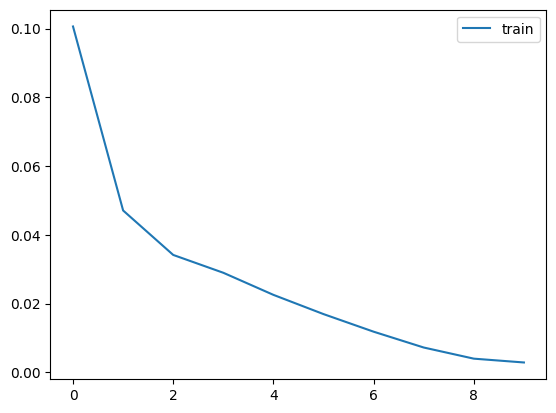

In [ ]:
pyplot.plot(history_2.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [ ]:
# model_2.save('/content/drive/MyDrive/sem-8/nlp/NLP Package/model_2.h5')

In [ ]:
# model_2 = load_model('/content/drive/MyDrive/sem-8/nlp/NLP Package/model_2.h5')

In [ ]:
X_test_new_2 = np.reshape(X_test_2,(X_test_2.shape[0], X_test_2.shape[1],1))
predicted_value_2 = model_2.predict(X_test_new_2)

1/1 [==============================] - 1s 746ms/step


In [ ]:
y_test_2

array([[0.58481339],
       [0.55090254],
       [0.52693763],
       [0.93372549],
       [0.0693909 ],
       [0.13870286],
       [0.14959286],
       [0.2046427 ],
       [0.35928112],
       [0.54753991],
       [0.53453126],
       [0.93735659],
       [0.08827868],
       [0.04449139],
       [0.13282056],
       [0.22688998],
       [0.35561219],
       [0.56323231],
       [0.49855232],
       [0.78202664],
       [0.98280783],
       [0.09136032],
       [0.0513967 ],
       [0.33770009],
       [0.67265321],
       [1.        ]])

In [ ]:
predicted_value_2

array([[0.6260173 ],
       [0.5562228 ],
       [0.51224273],
       [0.8252526 ],
       [0.07405789],
       [0.13946772],
       [0.12514557],
       [0.15746415],
       [0.34237322],
       [0.54248536],
       [0.506037  ],
       [0.8156983 ],
       [0.14679807],
       [0.04006363],
       [0.18805008],
       [0.22575131],
       [0.3319679 ],
       [0.5584527 ],
       [0.5021123 ],
       [0.7556348 ],
       [0.82876545],
       [0.09545446],
       [0.06622379],
       [0.3447098 ],
       [0.6667537 ],
       [0.84554714]], dtype=float32)

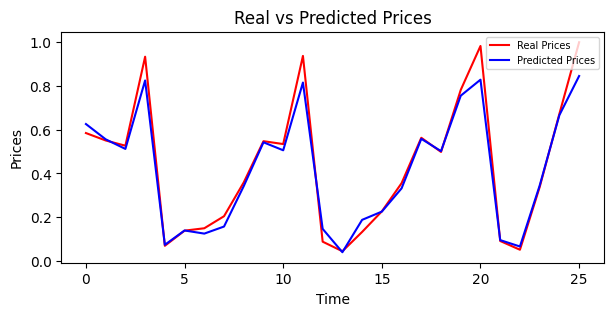

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(y_test_2,'red',label='Real Prices')
plt.plot(predicted_value_2,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=7)

In [ ]:
print("MAE: ", mean_absolute_error(y_test_2, predicted_value_2))
print("RMSE: ", np.sqrt(mean_squared_error(y_test_2, predicted_value_2)))
print("R2 Score: ", r2_score(y_test_2, predicted_value_2))

MAE:  0.036033899397790475
RMSE:  0.058233751326999
R2 Score:  0.9637850640414108


## Predcition with sentiment score LSTM

In [ ]:
X_3 = df.drop(['Date', 'Adj Close'], axis = 1)
y_3 = df.iloc[:, 4:5]

In [ ]:
# X = df[['sentiment score']]

In [ ]:
scaler = MinMaxScaler()
X_normalized_3 = scaler.fit_transform(X_3)
y_normalized_3 = scaler.fit_transform(y_3)

i_split = int(len(df) * 0.9)

X_train_3 = X_normalized_3[:i_split, :]
y_train_3 = y_normalized_3[:i_split, :]
X_test_3 = X_normalized_3[i_split:,:]
y_test_3 = y_normalized_3[i_split:,:]

In [ ]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
X_train_new_3 = np.reshape(X_train_3,(X_train_3.shape[0],X_train_3.shape[1],1))

In [ ]:
model_3 = Sequential()

model_3.add(LSTM(units = 5,kernel_initializer='glorot_uniform',return_sequences=True,input_shape=(X_train_new_3.shape[1],1)))

model_3.add(LSTM(units = 2,kernel_initializer='glorot_uniform'))

model_3.add(Dense(units = 1))

In [ ]:
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_3.fit(X_train_3, y_train_3, batch_size = 10, epochs = 10)

Epoch 1/10
23/23 [==============================] - 4s 7ms/step - loss: 0.1743
Epoch 2/10
23/23 [==============================] - 0s 8ms/step - loss: 0.1182
Epoch 3/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0785
Epoch 4/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0535
Epoch 5/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0442
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0391
Epoch 7/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0328
Epoch 8/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0260
Epoch 9/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 10/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0123


In [ ]:
model_3.save('/content/drive/MyDrive/sem-8/nlp/NLP Package/model_3.h5')

In [ ]:
model_3 = load_model('/content/drive/MyDrive/sem-8/nlp/NLP Package/model_3.h5')

In [ ]:
X_test_new_3 = np.reshape(X_test_3,(X_test_3.shape[0], X_test_3.shape[1],1))
predicted_value_3 = model_3.predict(X_test_new_3)

1/1 [==============================] - 1s 780ms/step


In [ ]:
y_test_3

array([[0.58481339],
       [0.55090254],
       [0.52693763],
       [0.93372549],
       [0.0693909 ],
       [0.13870286],
       [0.14959286],
       [0.2046427 ],
       [0.35928112],
       [0.54753991],
       [0.53453126],
       [0.93735659],
       [0.08827868],
       [0.04449139],
       [0.13282056],
       [0.22688998],
       [0.35561219],
       [0.56323231],
       [0.49855232],
       [0.78202664],
       [0.98280783],
       [0.09136032],
       [0.0513967 ],
       [0.33770009],
       [0.67265321],
       [1.        ]])

In [ ]:
predicted_value_3

array([[0.54723054],
       [0.4983712 ],
       [0.467208  ],
       [0.7679288 ],
       [0.18313867],
       [0.22075704],
       [0.21643713],
       [0.23795608],
       [0.34829178],
       [0.48614907],
       [0.46256292],
       [0.7591224 ],
       [0.21505818],
       [0.16659668],
       [0.24253443],
       [0.2712862 ],
       [0.34288347],
       [0.49996516],
       [0.45759732],
       [0.6717797 ],
       [0.7576548 ],
       [0.19500676],
       [0.17672917],
       [0.34828392],
       [0.5839068 ],
       [0.7765775 ]], dtype=float32)

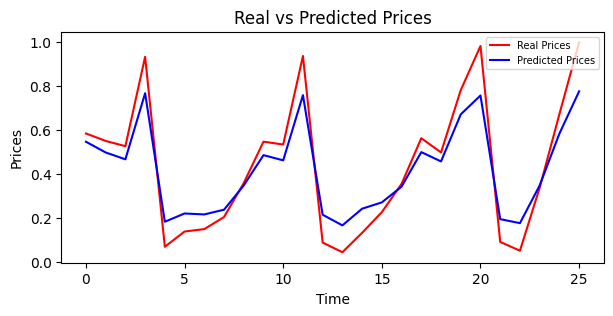

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(y_test_3,'red',label='Real Prices')
plt.plot(predicted_value_3,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=7)

In [ ]:
print("MAE: ", mean_absolute_error(y_test_3, predicted_value_3))
print("RMSE: ", np.sqrt(mean_squared_error(y_test_3, predicted_value_3)))
print("R2 Score: ", r2_score(y_test_3, predicted_value_3))

MAE:  0.09004846977939375
RMSE:  0.10730109849902109
R2 Score:  0.8770449070158475
